In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1213_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230130_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230113_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1030_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230102_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230203_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/0928_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/0905_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1002_UkraineCombinedTweetsDeduped.csv.gzip
/kaggle/input/ukraine

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# important libraries
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
all_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path=os.path.join(dirname, filename)
        all_files.append(full_path)

In [4]:
# sort the files
all_files.sort()

In [5]:
# fetch all February files - filenames containing "FEB" or "202202"
feb_files = [file for file in all_files if re.search(r"FEB", file) or re.search(r"202203", file)]
feb_files

['/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB27.csv.gzip',
 '/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip',
 '/kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part2.csv.gzip']

In [6]:
tmp_df_list = []
for file in feb_files:
    print(f"Reading in {file}")
    # unzip and read in the csv file as a dataframe
    tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
    # append dataframe to temp list
    tmp_df_list.append(tmp_df)

print("Concatenating the DataFrames")
# concatenate the dataframes in the temp list row-wise
df= pd.concat(tmp_df_list, axis=0)
print("Concatenation complete!")

Reading in /kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB27.csv.gzip
Reading in /kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Reading in /kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/UkraineCombinedTweetsDeduped_FEB28_part2.csv.gzip
Concatenating the DataFrames
Concatenation complete!


In [7]:
df.shape

(735189, 17)

In [8]:
df.columns

Index(['userid', 'username', 'acctdesc', 'location', 'following', 'followers',
       'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts',
       'retweetcount', 'text', 'hashtags', 'language', 'coordinates',
       'favorite_count', 'extractedts'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735189 entries, 1141800 to 140383
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   userid          735189 non-null  int64 
 1   username        735189 non-null  object
 2   acctdesc        575146 non-null  object
 3   location        429725 non-null  object
 4   following       735189 non-null  int64 
 5   followers       735189 non-null  int64 
 6   totaltweets     735189 non-null  int64 
 7   usercreatedts   735189 non-null  object
 8   tweetid         735189 non-null  int64 
 9   tweetcreatedts  735189 non-null  object
 10  retweetcount    735189 non-null  int64 
 11  text            735189 non-null  object
 12  hashtags        735189 non-null  object
 13  language        735189 non-null  object
 14  coordinates     68 non-null      object
 15  favorite_count  735189 non-null  int64 
 16  extractedts     735189 non-null  object
dtypes: int64(7), object(10)

In [10]:
df.isna().sum().sort_values(ascending=False)

coordinates       735121
location          305464
acctdesc          160043
userid                 0
retweetcount           0
favorite_count         0
language               0
hashtags               0
text                   0
tweetid                0
tweetcreatedts         0
username               0
usercreatedts          0
totaltweets            0
followers              0
following              0
extractedts            0
dtype: int64

In [11]:
earliest_tweet = df["tweetcreatedts"].min()
latest_tweet = df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-02-27 00:07:16, and the latest was at 2022-02-28 23:31:22


In [12]:
sentiment_df = df[['tweetid', 'text', 'hashtags', 'language']] # Filtering Columns
sentiment_df = sentiment_df.loc[sentiment_df['language'] == 'en'].reset_index(drop=True)  # Filtering language

In [13]:
sentiment_df['hashtags'] = sentiment_df.hashtags.map(lambda x: [i['text'] for i in eval(x)])  # Keeping only hashtags

In [15]:
sentiment_df.head

<bound method NDFrame.head of                     tweetid  \
0       1497724980259262467   
1       1497724980271984641   
2       1497724980573966346   
3       1497724980653694976   
4       1497724980833968129   
...                     ...   
469121  1498440720285253633   
469122  1498440720528683008   
469123  1498440720734109698   
469124  1498440721015078914   
469125  1498440721459679234   

                                                     text  \
0       #UkraineRussiaWar Captured Russian soldiers\n\...   
1       Like everybody else I am rooting for Ukraine t...   
2       We elected a game show host and got a clown. #...   
3       Ukrainian soldiers wearing sunflowers in their...   
4       russian troops destroyed a commercial oil base...   
...                                                   ...   
469121  Can @POTUS arrange to have #Zelensky zoom into...   
469122  The situation in #Ukraine is changing rapidly,...   
469123  A war where even librarians fight #Ukrai

PreProcessing Text

In [17]:
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

sentiment_df['text'] = sentiment_df['text'].apply(preprocess)

In [16]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# ROBERTA

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(device)

In [20]:
import urllib
import csv
labels=[]
task = 'sentiment'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [21]:
from scipy.special import softmax
from tqdm import tqdm  # import tqdm

BATCH_SIZE = 10
MAX_LEN = 128  # set maximum sequence length
scores_all = np.empty((0, len(labels)))
text_all = sentiment_df['text'].to_list()
n = len(text_all)

with torch.no_grad():
    for start_idx in tqdm(range(0, n, BATCH_SIZE)):  # add tqdm here
        end_idx = min(start_idx+BATCH_SIZE, n)
        batch_text = text_all[start_idx:end_idx]
        encoded_input = tokenizer.batch_encode_plus(batch_text, 
                                                     max_length=MAX_LEN,
                                                     padding='max_length',
                                                     truncation=True,
                                                     return_tensors='pt').to(device)
        output = model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()
        
sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)


100%|██████████| 46913/46913 [36:11<00:00, 21.61it/s]


In [28]:
sentiment_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", index=False)

Using the tensor and gpu increased the performance. From 1 iteration per second to 22 iterations per second. 5 hrs to 33 mins

In this updated code, batch_encode_plus is used to encode the batch of texts and generate input tensors of the same shape, with a fixed maximum sequence length of 128. Padding is added to the input sequences for those texts that are shorter than the maximum length, and truncation is applied to those that are longer. Note that the batch_encode_plus function returns a dictionary of input tensors, which are then converted to PyTorch tensors and moved to the device (GPU or CPU) using the to method.

# BOW

# SENTIMENT ANALYSIS DATASET BUILD

In [29]:
from textblob import TextBlob
def get_sentiment(tweet):
    sentiment = TextBlob(tweet).sentiment
    return sentiment.polarity, sentiment.subjectivity

sentiment_df['sentiment'] = sentiment_df['text'].apply(get_sentiment)

In [30]:
sentiment_df['polarity'] = sentiment_df['sentiment'].apply(lambda x:x[0])
sentiment_df['subjectivity'] = sentiment_df['sentiment'].apply(lambda x:x[0])

In [31]:
sentiment_df.drop('sentiment', axis=1, inplace=True)

In [32]:
sentiment_df.to_csv("./Tweets_Sentiment_Analysis_BOW_Raw_Values.csv", index=False)

# Emotion Analysis

In [33]:
emotion_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

emotion_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)

In [39]:
task='emotion'
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# WAIT

# Sentiment Analysis

> # Reading the Sentiment CSV data from RoBERTa

In [34]:
tweet_df = pd.read_csv("./Tweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", lineterminator='\n')

In [35]:
tweet_df.insert(7, "Sentiment", '')

In [36]:
for i in range(len(tweet_df)):
  if tweet_df['negative'][i] > tweet_df['positive'][i] and tweet_df['negative'][i] > tweet_df['neutral'][i]:
    tweet_df['Sentiment'][i] = 'negative'
  elif tweet_df['positive'][i] > tweet_df['negative'][i] and tweet_df['positive'][i] > tweet_df['neutral'][i]:
    tweet_df['Sentiment'][i]= 'positive'
  else:
    tweet_df['Sentiment'][i] = 'neutral'

In [37]:
tweet_df.drop(['negative','positive','neutral'], axis=1, inplace=True)

In [38]:
tweet_df.drop('language', axis=1, inplace=True)

In [39]:
tweet_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa.csv", index=False)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

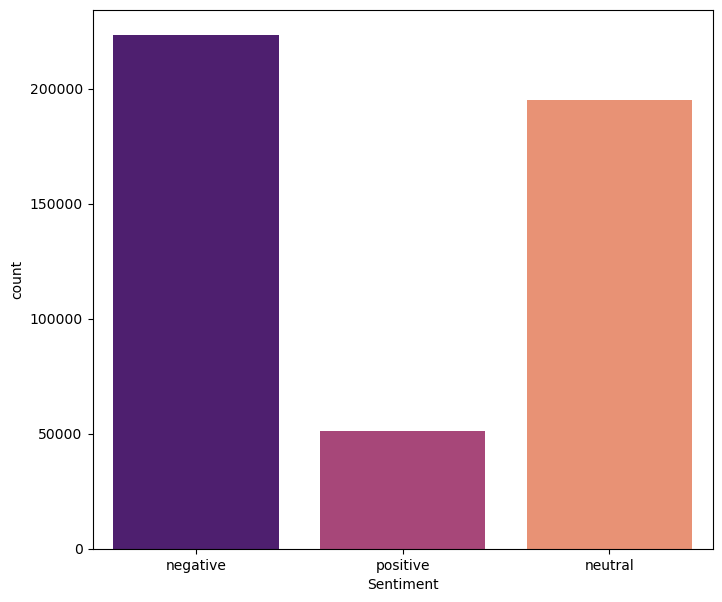

In [40]:
plt.figure(figsize = (8,7))
sns.countplot(x="Sentiment", data=tweet_df, palette='magma')

# Pre-Processing the Sentiment Dataframe

In [50]:
dataset = tweet_df[['Sentiment','text']]
text, sentiment = list(dataset['text']), list(dataset['Sentiment'])

In [51]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [52]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"#remove link
    userPattern       = '@[^\s]+'#remove tags
    alphaPattern      = "[^a-zA-Z0-9]"#remove alphanumeric charecters
    sequencePattern   = r"(.)\1\1+"#remove dots
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()#lowercase tweet
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [72]:
import time
import nltk
nltk.download('wordnet')
t = time.time()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
import nltk
print(nltk.data.path)

['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/path/to/nltk_data', '/root/nltk_data', '/root/nltk_data', '/kaggle/working/<path-to-nltk-data-directory>']


https://github.com/nltk/nltk/issues/3028 issues with wordnet so we needed to manually unzip

In [86]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/s

In [87]:
import time
import nltk
import os

nltk.data.path.append(os.path.abspath('<path-to-nltk-data-directory>'))

nltk.download('wordnet')

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds') 


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Text Preprocessing complete.
Time Taken: 82 seconds


In [88]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [89]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [90]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Evaluation

Bernoulli

In [91]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
ys_predict = BNBmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.92      0.92      0.92     11197
     neutral       0.86      0.90      0.88      9725
    positive       0.92      0.73      0.82      2535

    accuracy                           0.89     23457
   macro avg       0.90      0.85      0.87     23457
weighted avg       0.90      0.89      0.89     23457

Confusion Matrix: 
 [[10341   831    25]
 [  814  8772   139]
 [  117   558  1860]]
Accuracy Score: 
 0.8941041053843203


K Nearest Neighbors

In [92]:
KNNModel = KNeighborsClassifier(n_neighbors=5)
KNNModel.fit(X_train, y_train)
ys_predict = KNNModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.95      0.86      0.90     11197
     neutral       0.83      0.94      0.88      9725
    positive       0.91      0.81      0.86      2535

    accuracy                           0.89     23457
   macro avg       0.90      0.87      0.88     23457
weighted avg       0.89      0.89      0.89     23457

Confusion Matrix: 
 [[9677 1456   64]
 [ 473 9115  137]
 [  80  395 2060]]
Accuracy Score: 
 0.8889457304855694


Decision Tree Classifier

In [93]:
DTCModel = DecisionTreeClassifier(random_state=0)
DTCModel.fit(X_train, y_train)
ys_predict = DTCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.92      0.91      0.92     11197
     neutral       0.89      0.90      0.90      9725
    positive       0.89      0.86      0.87      2535

    accuracy                           0.90     23457
   macro avg       0.90      0.89      0.90     23457
weighted avg       0.90      0.90      0.90     23457

Confusion Matrix: 
 [[10245   822   130]
 [  786  8788   151]
 [  138   212  2185]]
Accuracy Score: 
 0.9045487487743531


Random Forest Classification

In [ ]:
RFCModel = RandomForestClassifier(n_estimators=100)
RFCModel.fit(X_train, y_train)
ys_predict = RFCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Logisitic Regression

In [96]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
ys_predict = LRmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Classification Report: 
               precision    recall  f1-score   support

    negative       0.95      0.96      0.96     11197
     neutral       0.94      0.94      0.94      9725
    positive       0.95      0.91      0.93      2535

    accuracy                           0.95     23457
   macro avg       0.95      0.94      0.94     23457
w

SVM

In [97]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
ys_predict = SVCmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.95      0.97      0.96     11197
     neutral       0.94      0.94      0.94      9725
    positive       0.95      0.92      0.93      2535

    accuracy                           0.95     23457
   macro avg       0.95      0.94      0.95     23457
weighted avg       0.95      0.95      0.95     23457

Confusion Matrix: 
 [[10808   364    25]
 [  503  9118   104]
 [   27   170  2338]]
Accuracy Score: 
 0.9491409813701667
